# CPSC-610-Project - Predicting Monthly Electricity Consumption
-------------------------------------------------------
### Professor: Mohannad AlMousa
-------------------------------------------------------
#### Students:
   * Jorge Roberto Ponce Martínez - NF1026980
   * Gina Sussileth Lutfallah Reyes - NF1024061
   * Luis Enrique Villalobos Socualaya - NF1031293 aaaaa
   * Isabel Marcia Chauca Reyes - NF1023326

#### Date: December 7th, 2025

## Project Overview

This project explores energy consumption patterns across hundreds of properties in Ontario.
The dataset consists of CSV files derived from the ENERGY STAR Portfolio Manager system.

Each CSV describes a different part of the data ecosystem:
   * Property characteristics
   * Meters installed at each property
   * Monthly energy consumption readings
   * How floor area is allocated to different use types

Each row in the meter entries dataset represents one monthly meter reading for a specific property.

Your main objective is to build a machine learning model that predicts monthly electricity consumption (usage) for buildings, using only readings from Electric – Grid meters (measured in kWh). 

The prediction target comes from the meter entries data, and you will need to extract the correct column and filter the dataset appropriately. You can use the attributes in these different files to help you in training your model.


### Inicialización

#### Libraries

In [117]:
# -----Libraries-----
# --- General Libraries
import os
import math

# --- Data Manipulation Libraries
import pandas as pd
import numpy as np

# --- Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning Libraries
# -- Scikit-Learn Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.utils import resample

# -- Scikit-Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# -- Scikit-Learn Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, mean_squared_error, r2_score


#### Variables and Constants

In [118]:
# -----Constansts
# ----Path file of data sets
c_pathfile=r"Data\\"

# ----Random state & Data handle variables
c_random_state = 56106
c_test_size = 0.20

#### Reutilizable Functions

In [119]:
def load_csv_to_dataframe(
    file_path,
    show_info=False, show_describe=False,
    show_head=False, head_rows=5,
    show_sample=False, sample_rows=5,
    parse_date=False, parse_index=0
):
    """
    Loads a CSV file into a pandas DataFrame and optionally displays information, the first few rows,
    or random samples.
    If parse_date flag is True the function will read the csv file with the parameters 'index_col' and
    'parse_dates'. In case the index of the date to parse is not in the first position you can use the
    parameter 'parse_index' to indicate the index in the file to parse.

    Args:
        file_path (str): The path to the CSV file.
        show_info (bool, optional): Flag to display DataFrame information. Defaults to False.
        show_describe (bool, optional): Flag to display DataFrame describe info. Defaults to False.
        show_head (bool, optional): Flag to display the first n_rows of the DataFrame. Defaults to False.
        head_rows (int, optional): Number of rows to show with '.head' of DF
        show_sample (bool, optional): Flag to display random samples of the DataFrame. Defaults to False.
        sample_rows (int, optional): Number of rows to show a sample of DF

    Returns:
        pandas.DataFrame: The DataFrame loaded from the CSV file.
    """

    # ----Try block in case of a runtimeerror reading files
    try:
        # ---Read file and get file name
        if parse_date == True:
            df = pd.read_csv(file_path, index_col=[parse_index], parse_dates=[parse_index])
        else:
            df = pd.read_csv(file_path)

        # --Get file name
        file_name = os.path.basename(file_path)
        
        # ---Show info of the new DataFrame if requested
        if show_info:
            print(f"\n***********DataFrame {file_name}***********")
            display(df.info())

        # ---Show info of the new DataFrame if requested
        if show_describe:
            print(f"\n***********DataFrame Describe {file_name}***********")
            display(df.describe())            
            
        # ---Show first rows of DataFrame if requested
        if show_head:
            print(f"\n***********First {head_rows} registers of DataFrame {file_name}***********")
            display(df.head(head_rows))

        # ---Show sample rows of DataFrame if requested
        if show_sample:
            print(f"\n***********Sampled registers {sample_rows} of DataFrame {file_name}***********")
            display(df.sample(sample_rows))
            
        return df

    # -File not found exception
    except FileNotFoundError:
        print(f"\nError: File not found at {file_path}")
        return None
    # -Any other runtime error
    except Exception as e:
        print(f"\nAn error occurred: {e}")
        return None

### Datasets Loading

In [120]:
# ----- Load Data to DataFrames

In [121]:
# --- Meters Entries DataFrame
df_meter_entries = load_csv_to_dataframe(
    (c_pathfile + "meter_entries.csv"),
    show_info = True, show_describe = True,
    show_head = True, head_rows = 5,
    show_sample = True, sample_rows = 5
)


***********DataFrame meter_entries.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26222 entries, 0 to 26221
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Property Name               26222 non-null  object 
 1   Portfolio Manager ID        26222 non-null  int64  
 2   Portfolio Manager Meter ID  26222 non-null  int64  
 3   Meter Name                  26222 non-null  object 
 4   Meter Type                  26222 non-null  object 
 5   Meter Consumption ID        26222 non-null  int64  
 6   Start Date                  26222 non-null  object 
 7   End Date                    26222 non-null  object 
 8   Usage/Quantity              26222 non-null  float64
 9   Usage Units                 26222 non-null  object 
 10  Cost ($)                    26222 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 2.2+ MB


None


***********DataFrame Describe meter_entries.csv***********


,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Consumption ID,Usage/Quantity
count,2.622200e+04,2.622200e+04,2.622200e+04,2.622200e+04
mean,3.499990e+07,1.901104e+08,8.451535e+09,5.543443e+04
std,5.203779e+02,4.339441e+04,1.675861e+04,3.420746e+05
min,3.499909e+07,1.899479e+08,8.451519e+09,-2.711012e+04
25%,3.499941e+07,1.900842e+08,8.451527e+09,3.670075e+02
50%,3.499988e+07,1.901101e+08,8.451534e+09,2.469450e+03
75%,3.500036e+07,1.901230e+08,8.451542e+09,1.366844e+04
max,3.500084e+07,1.901908e+08,8.451869e+09,1.199675e+07



***********First 5 registers of DataFrame meter_entries.csv***********


,Property Name,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Usage/Quantity,Usage Units,Cost ($)
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527469,2022-01-01 00:00:00,2022-02-01 00:00:00,42876.27,kWh (thousand Watt-hours),5775.7
1,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527470,2022-02-01 00:00:00,2022-03-01 00:00:00,39721.72,kWh (thousand Watt-hours),5377.67
2,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527471,2022-03-01 00:00:00,2022-04-01 00:00:00,41278.04,kWh (thousand Watt-hours),5611
3,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527472,2022-04-01 00:00:00,2022-05-01 00:00:00,37111.95,kWh (thousand Watt-hours),4989.06
4,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527473,2022-05-01 00:00:00,2022-06-01 00:00:00,41778.27,kWh (thousand Watt-hours),5984.66



***********Sampled registers 5 of DataFrame meter_entries.csv***********


,Property Name,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Usage/Quantity,Usage Units,Cost ($)
4535,Chaplin Parkette,34999648,190084258,AUTO_Chaplin Parkette-Electric,Electric - Grid,8451525785,2022-01-01 00:00:00,2022-02-01 00:00:00,2044.74,kWh (thousand Watt-hours),338.93
23355,Sunnydale Acres Park,35000027,190084479,AUTO_Sunnydale Acres Park-Natural Gas,Natural Gas,8451520810,2022-02-01 00:00:00,2022-03-01 00:00:00,2640.92,cm (cubic meters),1217.67
22028,Parks Various Locations,34999932,190117447,AUTO_Parks Various Locations-Electric,Electric - Grid,8451535394,2022-02-01 00:00:00,2022-03-01 00:00:00,68545.86,kWh (thousand Watt-hours),12794.53
2628,Fire Station 223,34999334,190084216,AUTO_Fire Station 223-Natural Gas,Natural Gas,8451524323,2022-08-01 00:00:00,2022-09-01 00:00:00,71.97,cm (cubic meters),117.84
18367,Port Union Community Recreation Centre,34999247,190117670,AUTO_Port Union Community Recreation Centre-Na...,Natural Gas,8451531261,2022-02-01 00:00:00,2022-03-01 00:00:00,4176.41,cm (cubic meters),1563.14


In [122]:
# --- Meters DataFrame
df_meters = load_csv_to_dataframe(
    (c_pathfile + "meters.csv"),
    show_info = True, show_describe = True,
    show_head = True, head_rows = 5,
    show_sample = True, sample_rows = 5,
)


***********DataFrame meters.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2585 entries, 0 to 2584
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Property Name                   2585 non-null   object
 1   Portfolio Manager ID            2585 non-null   int64 
 2   Portfolio Manager Meter ID      2585 non-null   int64 
 3   Meter Name                      2585 non-null   object
 4   Meter Type                      2585 non-null   object
 5   Units                           2585 non-null   object
 6   First Day of First Meter Entry  2585 non-null   object
 7   Last Day of Last Meter Entry    2585 non-null   object
dtypes: int64(2), object(6)
memory usage: 161.7+ KB


None


***********DataFrame Describe meters.csv***********


,Portfolio Manager ID,Portfolio Manager Meter ID
count,2.585000e+03,2.585000e+03
mean,3.500011e+07,1.901116e+08
std,9.661911e+03,6.247399e+04
min,3.499909e+07,1.899479e+08
25%,3.499943e+07,1.900843e+08
50%,3.499992e+07,1.901103e+08
75%,3.500039e+07,1.901299e+08
max,3.549044e+07,1.924236e+08



***********First 5 registers of DataFrame meters.csv***********


,Property Name,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Units,First Day of First Meter Entry,Last Day of Last Meter Entry
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-09-01 00:00:00
1,#13 Police Division,35000258,189947942,AUTO_#13 Police Division-Natural Gas,Natural Gas,cm (cubic meters),2010-01-01 00:00:00,2024-09-01 00:00:00
2,#22 Police Division,35000260,189947959,AUTO_#22 Police Division-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-05-01 00:00:00
3,#22 Police Division,35000260,189947960,AUTO_#22 Police Division-Natural Gas,Natural Gas,cm (cubic meters),2010-01-01 00:00:00,2024-05-01 00:00:00
4,#23 Police Division,35000261,189947990,AUTO_#23 Police Division-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-01-01 00:00:00



***********Sampled registers 5 of DataFrame meters.csv***********


,Property Name,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Units,First Day of First Meter Entry,Last Day of Last Meter Entry
1450,Kenaston Park,34999829,190077903,AUTO_Kenaston Park-Electric,Electric - Grid,kWh (thousand Watt-hours),2018-11-06 00:00:00,2024-11-01 00:00:00
1319,Armour Heights Pumping Station,35000819,190131233,Armour Heights Pumping Station Flow,Average Influent Flow,Cubic Meters per Day,2011-01-01 00:00:00,2023-12-31 00:00:00
1997,Street Lighting Scarborough,35000585,190084405,AUTO_Street Lighting Scarborough-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-11-01 00:00:00
136,Fire Prevention Office,34999304,190082494,AUTO_Fire Prevention Office-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-01-01 00:00:00
1623,Lower Riverwood Landfill,35000804,190110221,AUTO_Lower Riverwood Landfill-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-11-01 00:00:00


In [123]:
# --- Properties DataFrame
df_properties = load_csv_to_dataframe(
    (c_pathfile + "properties.csv"),
    show_info = True, show_describe = True,
    show_head = True, head_rows = 5,
    show_sample = True, sample_rows = 5
)


***********DataFrame properties.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Property Name                  1760 non-null   object
 1   Portfolio Manager ID           1760 non-null   int64 
 2   Street Address                 1760 non-null   object
 3   City/Municipality              1760 non-null   object
 4   Postal Code                    1760 non-null   object
 5   Property Type - Self-Selected  1760 non-null   object
 6   Gross Floor Area               1760 non-null   int64 
 7   Occupancy (%)                  1760 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 110.1+ KB


None


***********DataFrame Describe properties.csv***********


,Portfolio Manager ID,Gross Floor Area,Occupancy (%)
count,1.760000e+03,1760.000000,1760.000000
mean,3.500208e+07,17091.905114,93.323864
std,7.642958e+04,62367.818943,24.939442
min,3.391273e+07,1.000000,0.000000
25%,3.499953e+07,1.000000,100.000000
50%,3.499997e+07,299.500000,100.000000
75%,3.500041e+07,10984.500000,100.000000
max,3.710396e+07,986748.000000,100.000000



***********First 5 registers of DataFrame properties.csv***********


,Property Name,Portfolio Manager ID,Street Address,City/Municipality,Postal Code,Property Type - Self-Selected,Gross Floor Area,Occupancy (%)
0,#11 Police Division - OLD,34999087,209 MAVETY ST,Toronto,M6P 2M1,Office,21119,100
1,#14 Police Division - OLD,34999088,150 HARRISON ST,Toronto,M6J 2A4,Office,24197,100
2,175 Memorial Park Ave,34999089,175 MEMORIAL PARK AVE,Toronto,M4J 2K5,Office,6394,100
3,18 Dyas Rd.,34999090,18 DYAS RD,North York,M3B 1V5,Office,73927,100
4,2 Civic Centre Court,34999091,2 CIVIC CENTRE CRT,Etobicoke,M9C 5A3,Office,46145,100



***********Sampled registers 5 of DataFrame properties.csv***********


,Property Name,Portfolio Manager ID,Street Address,City/Municipality,Postal Code,Property Type - Self-Selected,Gross Floor Area,Occupancy (%)
286,Carpark 164,35000141,453 SPADINA RD,Toronto,M5P 2W5,Parking,55,100
1049,Oakridge Seniors Bocce Club,34999244,6 THORA AVE,Scarborough,M1L 2P8,Social/Meeting Hall,4004,100
1178,Long Branch Park,34999862,245 LAKE PROMENADE,Etobicoke,M8W 1A6,Other - Public Services,1,100
1058,Seneca Village Community Centre,34999253,1700 FINCH AVE E,North York,M2J 4X8,Social/Meeting Hall,9408,100
658,Fire Station 125,34999314,1109 LESLIE ST,North York,M3C 2J7,Fire Station,5813,100


In [124]:
# --- Uses DataFrame and Preview
df_uses = load_csv_to_dataframe(
    (c_pathfile + "uses.csv"),
    show_info = True, show_describe = True,
    show_head = True, head_rows = 5,
    show_sample = True, sample_rows = 5
)


***********DataFrame uses.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Property Name                            1760 non-null   object 
 1   Portfolio Manager ID                     1760 non-null   int64  
 2   Property Use Name                        1760 non-null   object 
 3   Use Type                                 1760 non-null   object 
 4   Gross Floor Area for Use                 1589 non-null   float64
 5   Gross Floor Area Units                   1589 non-null   object 
 6   Gross Floor Area Temporary Value? (Y/N)  1760 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 96.4+ KB


None


***********DataFrame Describe uses.csv***********


,Portfolio Manager ID,Gross Floor Area for Use
count,1.760000e+03,1589.000000
mean,3.500208e+07,15495.478288
std,7.642958e+04,59419.006156
min,3.391273e+07,0.000000
25%,3.499953e+07,0.000000
50%,3.499997e+07,217.000000
75%,3.500041e+07,8633.000000
max,3.710396e+07,986748.000000



***********First 5 registers of DataFrame uses.csv***********


,Property Name,Portfolio Manager ID,Property Use Name,Use Type,Gross Floor Area for Use,Gross Floor Area Units,Gross Floor Area Temporary Value? (Y/N)
0,#11 Police Division - OLD,34999087,Building Use,Office,21119.0,Sq. Ft.,No
1,#14 Police Division - OLD,34999088,Building Use,Office,24197.0,Sq. Ft.,No
2,175 Memorial Park Ave,34999089,Building Use,Office,6394.0,Sq. Ft.,No
3,18 Dyas Rd.,34999090,Building Use,Office,73927.0,Sq. Ft.,No
4,2 Civic Centre Court,34999091,Building Use,Office,46145.0,Sq. Ft.,No



***********Sampled registers 5 of DataFrame uses.csv***********


,Property Name,Portfolio Manager ID,Property Use Name,Use Type,Gross Floor Area for Use,Gross Floor Area Units,Gross Floor Area Temporary Value? (Y/N)
526,High Park Tennis Club,34999784,Building Use,Other - Public Services,169.0,Sq. Ft.,No
1430,Village of Yorkville Park,35000065,Building Use,Other - Public Services,58.0,Sq. Ft.,No
855,1605 King St. W,35000558,Building Use,Other - Public Services,0.0,Sq. Ft.,No
158,Fire Station 344,34999367,Building Use,Fire Station,11238.0,Sq. Ft.,No
662,Carpark 521,35000223,Parking Lots and Garages,Parking,NaN,NaN,Not Available


#### Insights and Actions

   * Data Type Conversion: The date columns in meter_entries are strings (objects) and need to be datetime objects.

   * Filter Target Data: The project specifically asks to predict "Electric – Grid" consumption. The dataset currently mixes Electricity and Natural Gas.

   * Handle Inconsistencies: The described showed a minimum Usage/Quantity of -27,110. Negative electricity usage is likely an error that shouldn't be in a consumption prediction model. We should remove these.

   * Merge Data: To predict consumption based on building features, we need to combine the Consumption data (meter_entries) with the Building data (properties).

### Data Cleaning

Prepare the dataset for meaningful analysis.
   * Identify and handle missing values
(note: some fields use placeholders such as “Not Available”).
   * Review and remove duplicates, inconsistencies, or invalid records.
   * Ensure all columns use appropriate data types.
   * Standardize categorical values where needed.
 Document any assumptions or decisions you make.
   * In your report, clearly describe the major cleaning steps you performed and any issues you discovered.


In [125]:
# ----- 1. Fix Data Types: Convert Date columns to datetime
date_cols = ["Start Date", "End Date"]
df_meter_entries[date_cols] = df_meter_entries[date_cols].apply(lambda col: pd.to_datetime(col, errors='coerce'))

# ----- 2. Filter Data: Select only "Electric - Grid" meters
df_meter_entries_electric = df_meter_entries[
    (df_meter_entries["Meter Type"] == "Electric - Grid") & 
    (df_meter_entries["Usage Units"] == "kWh (thousand Watt-hours)")
].copy()

print(f"Original Entries: {len(df_meter_entries)}")
print(f"Electric Entries: {len(df_meter_entries_electric)}")

Original Entries: 26222
Electric Entries: 18109


In [126]:
# ----- 3. Handle Inconsistencies
# ---Check for negative or zero usage.
negative_usage = df_meter_entries_electric[df_meter_entries_electric["Usage/Quantity"] <= 0]
print(f"Found {len(negative_usage)} rows with <= 0 usage.")

# ---Remove these rows
df_meter_entries_electric = df_meter_entries_electric[df_meter_entries_electric["Usage/Quantity"] > 0]
print(f"Rows after removing invalid usage: {len(df_meter_entries_electric)}")

Found 389 rows with <= 0 usage.
Rows after removing invalid usage: 17720


In [127]:
# ----- 4. Merge with Property Data
# --- We merge on "Portfolio Manager ID" to attach building info to each meter reading
df_merged = pd.merge(
    df_meter_entries_electric, 
    df_properties, 
    on="Portfolio Manager ID", 
    how="left"
)

# --- Rename columns
df_merged = df_merged.rename(columns={
    "Usage/Quantity": "Electricity_Usage_kWh",
    "Gross Floor Area": "Gross_Floor_Area_sqft",
    "Property Type - Self-Selected": "Property_Type"
})

# --- Check the new dataframe
print(f"Merged DataFrame Shape: {df_merged.shape}")
df_merged.head()

Merged DataFrame Shape: (17720, 18)


,Property Name_x,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Electricity_Usage_kWh,Usage Units,Cost ($),Property Name_y,Street Address,City/Municipality,Postal Code,Property_Type,Gross_Floor_Area_sqft,Occupancy (%)
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527469,2022-01-01,2022-02-01,42876.27,kWh (thousand Watt-hours),5775.7,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
1,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527470,2022-02-01,2022-03-01,39721.72,kWh (thousand Watt-hours),5377.67,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
2,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527471,2022-03-01,2022-04-01,41278.04,kWh (thousand Watt-hours),5611,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
3,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527472,2022-04-01,2022-05-01,37111.95,kWh (thousand Watt-hours),4989.06,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
4,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527473,2022-05-01,2022-06-01,41778.27,kWh (thousand Watt-hours),5984.66,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100


In [128]:
# ----- 5. Missing Value Analysis
print("Missing Values per Column:")
display(df_merged.info())
print("*" * 50)
display(df_merged.describe())
print("*" * 50)
display(df_merged)

Missing Values per Column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Property Name_x             17720 non-null  object        
 1   Portfolio Manager ID        17720 non-null  int64         
 2   Portfolio Manager Meter ID  17720 non-null  int64         
 3   Meter Name                  17720 non-null  object        
 4   Meter Type                  17720 non-null  object        
 5   Meter Consumption ID        17720 non-null  int64         
 6   Start Date                  17720 non-null  datetime64[ns]
 7   End Date                    17720 non-null  datetime64[ns]
 8   Electricity_Usage_kWh       17720 non-null  float64       
 9   Usage Units                 17720 non-null  object        
 10  Cost ($)                    17720 non-null  object        
 11  Property Name_y            

None

**************************************************


,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Consumption ID,Start Date,End Date,Electricity_Usage_kWh,Gross_Floor_Area_sqft,Occupancy (%)
count,1.772000e+04,1.772000e+04,1.772000e+04,17720,17720,1.772000e+04,17720.000000,17720.000000
mean,3.499996e+07,1.901101e+08,8.451535e+09,2022-06-01 11:25:37.516930048,2022-07-01 19:36:22.753950464,7.764462e+04,17925.392833,93.922122
min,3.499909e+07,1.899479e+08,8.451519e+09,2022-01-01 00:00:00,2022-01-07 00:00:00,1.000000e-02,1.000000,0.000000
25%,3.499951e+07,1.900835e+08,8.451527e+09,2022-03-01 00:00:00,2022-04-01 00:00:00,6.150475e+02,1.000000,100.000000
50%,3.499997e+07,1.901100e+08,8.451536e+09,2022-06-01 00:00:00,2022-07-01 00:00:00,4.630765e+03,329.000000,100.000000
75%,3.500040e+07,1.901223e+08,8.451543e+09,2022-09-01 00:00:00,2022-10-01 00:00:00,2.530980e+04,11765.000000,100.000000
max,3.500084e+07,1.901908e+08,8.451550e+09,2022-11-01 00:00:00,2022-12-01 00:00:00,1.199675e+07,986748.000000,100.000000
std,5.102685e+02,4.300700e+04,8.919796e+03,NaN,NaN,4.126198e+05,64466.442147,23.893083


**************************************************


,Property Name_x,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Electricity_Usage_kWh,Usage Units,Cost ($),Property Name_y,Street Address,City/Municipality,Postal Code,Property_Type,Gross_Floor_Area_sqft,Occupancy (%)
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527469,2022-01-01,2022-02-01,42876.27,kWh (thousand Watt-hours),5775.7,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
1,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527470,2022-02-01,2022-03-01,39721.72,kWh (thousand Watt-hours),5377.67,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
2,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527471,2022-03-01,2022-04-01,41278.04,kWh (thousand Watt-hours),5611,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
3,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527472,2022-04-01,2022-05-01,37111.95,kWh (thousand Watt-hours),4989.06,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
4,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527473,2022-05-01,2022-06-01,41778.27,kWh (thousand Watt-hours),5984.66,#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17715,Keele Valley Landfill,34999483,190190809,AUTO_Keele Valley Landfill-Electric,Electric - Grid,8451520095,2022-07-01,2022-08-01,128663.74,kWh (thousand Watt-hours),22978.09,Keele Valley Landfill,200 McNaughton Rd,Maple,L6A 4E2,Other - Public Services,10764,100
17716,Keele Valley Landfill,34999483,190190809,AUTO_Keele Valley Landfill-Electric,Electric - Grid,8451520096,2022-08-01,2022-09-01,130740.94,kWh (thousand Watt-hours),21555.43,Keele Valley Landfill,200 McNaughton Rd,Maple,L6A 4E2,Other - Public Services,10764,100
17717,Keele Valley Landfill,34999483,190190809,AUTO_Keele Valley Landfill-Electric,Electric - Grid,8451520097,2022-09-01,2022-10-01,128677.72,kWh (thousand Watt-hours),17504.66,Keele Valley Landfill,200 McNaughton Rd,Maple,L6A 4E2,Other - Public Services,10764,100
17718,Keele Valley Landfill,34999483,190190809,AUTO_Keele Valley Landfill-Electric,Electric - Grid,8451520098,2022-10-01,2022-11-01,141462.78,kWh (thousand Watt-hours),13056,Keele Valley Landfill,200 McNaughton Rd,Maple,L6A 4E2,Other - Public Services,10764,100


### Exploratory Data Analysis (EDA)

Develop a solid understanding of the dataset.
   * Compute summary statistics for relevant features.
   * Explore distributions and major patterns.
   * Examine how different attributes relate to the target variable.
   * Identify correlations, trends, or unusual observations.
   * In your report, present the most meaningful findings, not every calculation.


In [129]:
# ----- 1. Summary Statistics
print("*" * 20, "Numeric Summary Statistics", "*" * 20)
display(df_merged.describe(include=[np.number]).T)

print("\n", "*" * 20, "Categorical Summary Statistics", "*" * 20)
display(df_merged.describe(include=["object"]).T)

******************** Numeric Summary Statistics ********************


,count,mean,std,min,25%,50%,75%,max
Portfolio Manager ID,17720.0,3.499996e+07,510.268534,3.499909e+07,3.499951e+07,3.499997e+07,3.500040e+07,3.500084e+07
Portfolio Manager Meter ID,17720.0,1.901101e+08,43006.996405,1.899479e+08,1.900835e+08,1.901100e+08,1.901223e+08,1.901908e+08
Meter Consumption ID,17720.0,8.451535e+09,8919.795535,8.451519e+09,8.451527e+09,8.451536e+09,8.451543e+09,8.451550e+09
Electricity_Usage_kWh,17720.0,7.764462e+04,412619.846161,1.000000e-02,6.150475e+02,4.630765e+03,2.530980e+04,1.199675e+07
Gross_Floor_Area_sqft,17720.0,1.792539e+04,64466.442147,1.000000e+00,1.000000e+00,3.290000e+02,1.176500e+04,9.867480e+05
Occupancy (%),17720.0,9.392212e+01,23.893083,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02



 ******************** Categorical Summary Statistics ********************


,count,unique,top,freq
Property Name_x,17720,1632,Train Storage Building,11
Meter Name,17720,1632,AUTO_Train Storage Building-Electric,11
Meter Type,17720,1,Electric - Grid,17720
Usage Units,17720,1,kWh (thousand Watt-hours),17720
Cost ($),17720,16422,20.98,24
Property Name_y,17720,1632,Train Storage Building,11
Street Address,17720,1554,1873 Bloor St. W,44
City/Municipality,17720,12,Toronto,9265
Postal Code,17720,1377,M5V 3C6,165
Property_Type,17720,15,Other - Public Services,8594


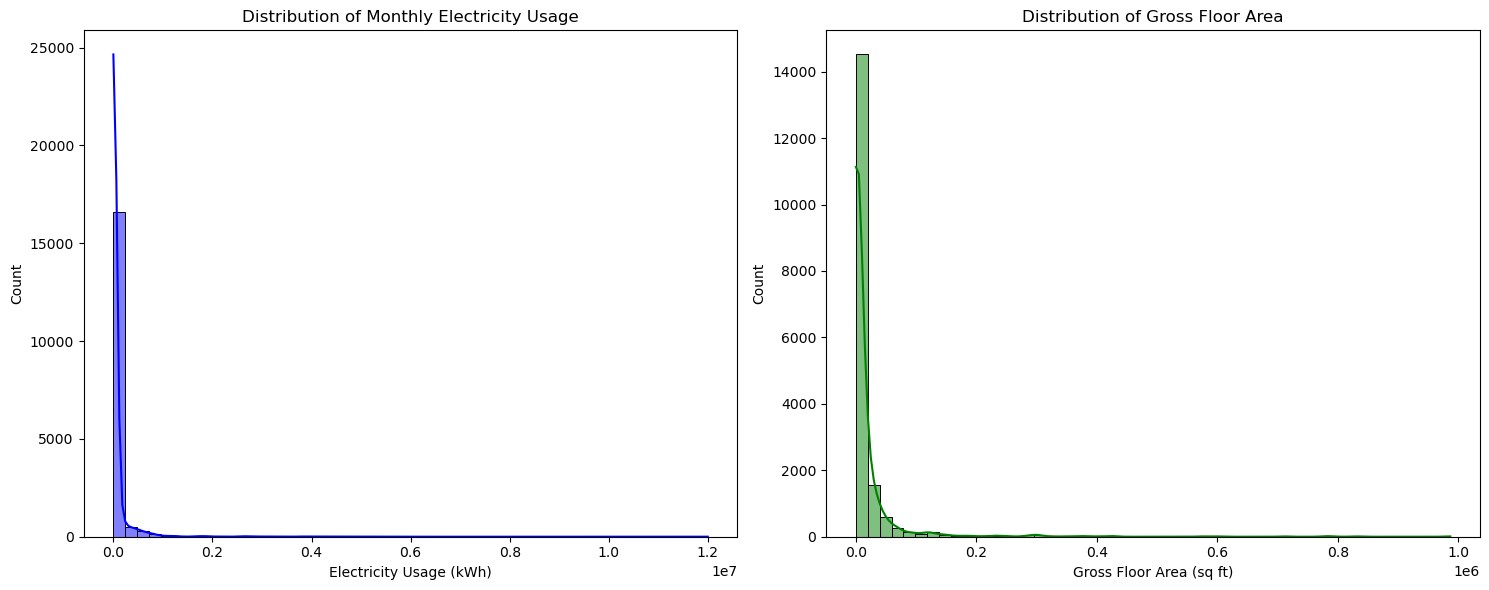

In [130]:
# ----- 2. Distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Plot 1: Distribution of Electricity Usage
sns.histplot(
    data = df_merged["Electricity_Usage_kWh"],
    bins = 50,
    kde = True,
    ax = axes[0],
    color = "blue")
axes[0].set_title("Distribution of Monthly Electricity Usage")
axes[0].set_xlabel("Electricity Usage (kWh)")

# --- Plot 2: Distribution of Gross Floor Area
sns.histplot(
    df_merged["Gross_Floor_Area_sqft"],
    bins = 50,
    kde = True,
    ax = axes[1],
    color = "green")
axes[1].set_title("Distribution of Gross Floor Area")
axes[1].set_xlabel("Gross Floor Area (sq ft)")

plt.tight_layout()
plt.show()

***Insight:***
   * We have a "long tail" to the right, it means we have outliers (a skewed distribution).

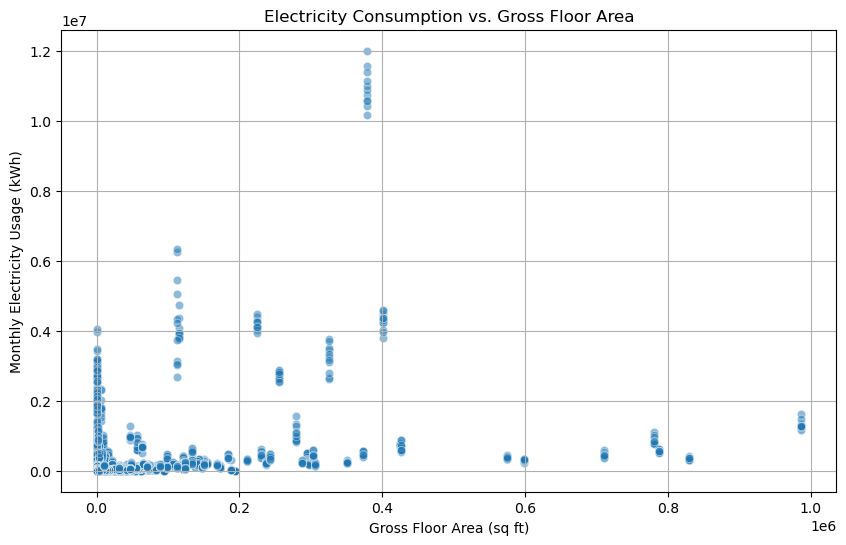

In [131]:
# ----- 3. Relationship: Floor Area vs. Energy Consumption
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data = df_merged,
    x = "Gross_Floor_Area_sqft",
    y = "Electricity_Usage_kWh",
    alpha = 0.5)
plt.title("Electricity Consumption vs. Gross Floor Area")
plt.xlabel("Gross Floor Area (sq ft)")
plt.ylabel("Monthly Electricity Usage (kWh)")
plt.grid(True)
plt.show()


***Insight Check:***
   * There is no clear lineal relationship between Gross Floor Area and Monthly Electricity Usage.
   * There is a presence of outliers.
   * High concentration near the origin.

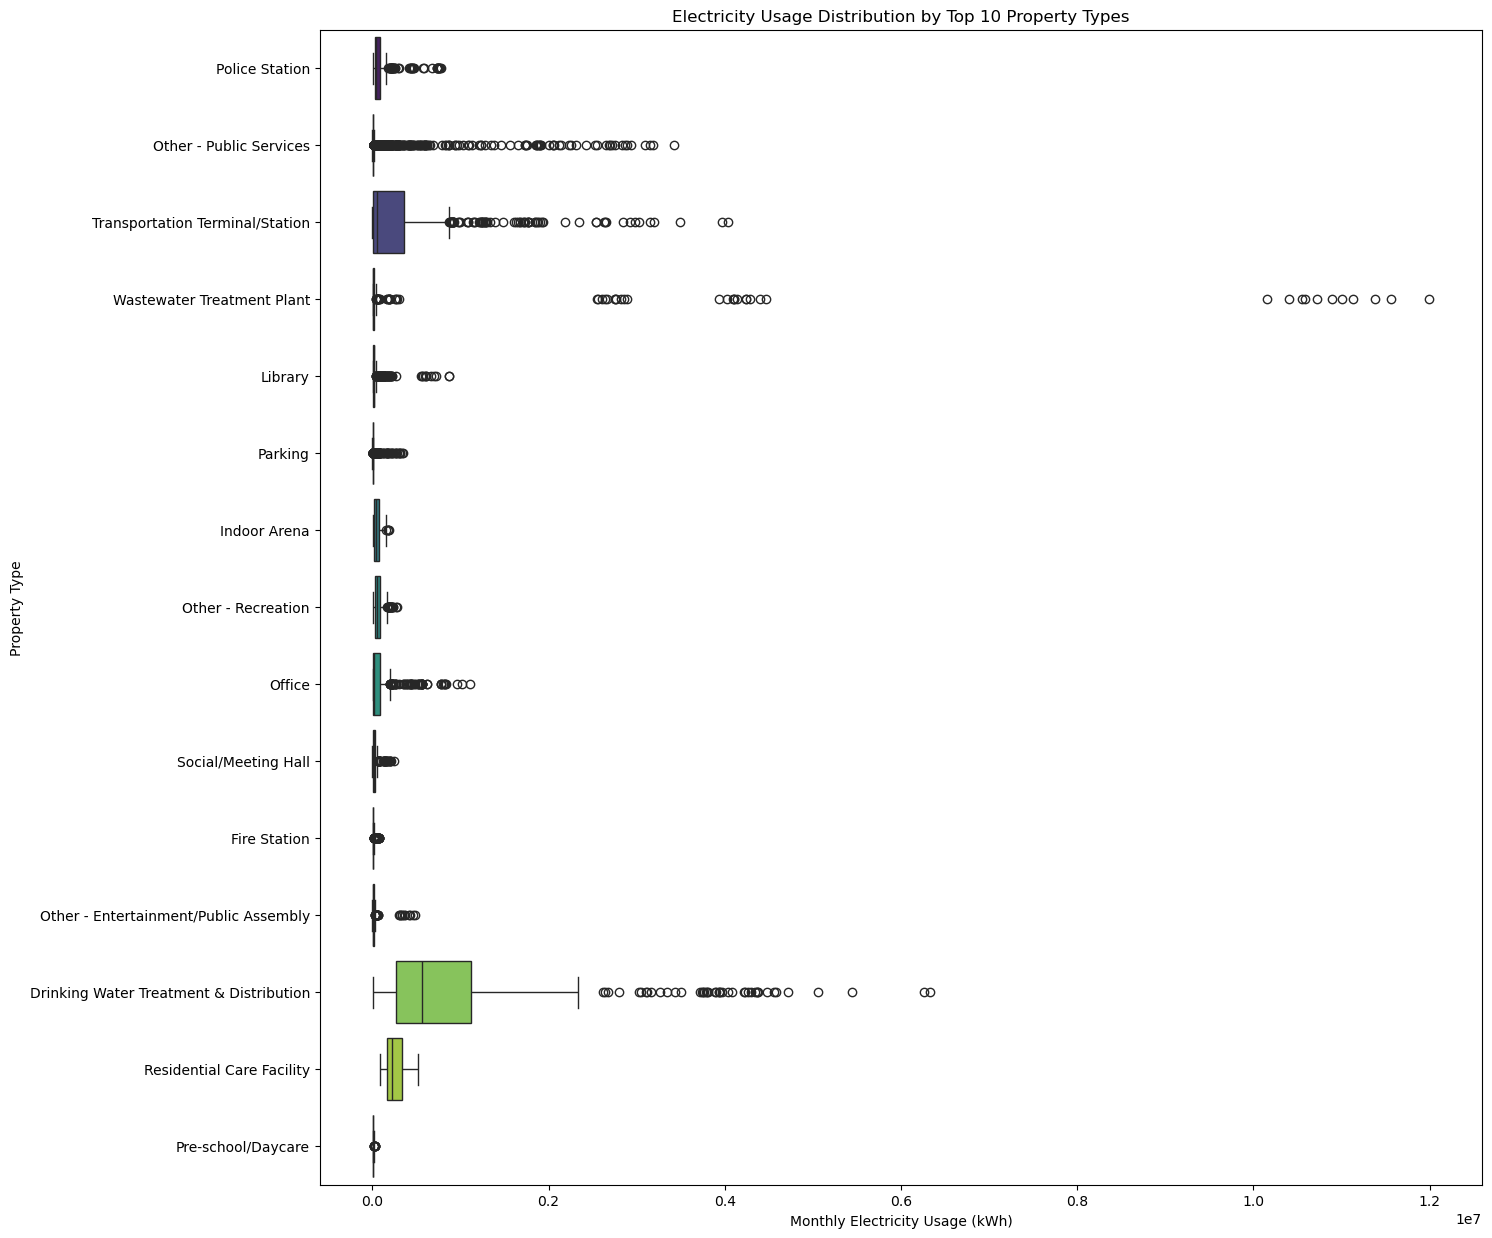

In [132]:
# ----- 4. Consumption by Property Type
plt.figure(figsize=(15, 15))
sns.boxplot(
    data = df_merged, 
    x = "Electricity_Usage_kWh", 
    y = "Property_Type",
    hue = "Property_Type",
    legend = False,
    palette = "viridis")

plt.title("Electricity Usage Distribution by Top 10 Property Types")
plt.xlabel("Monthly Electricity Usage (kWh)")
plt.ylabel("Property Type")
plt.show()

,Property_Type,Electricity_Usage_kWh
0,Drinking Water Treatment & Distribution,2.886068e+08
1,Fire Station,9.496249e+06
2,Indoor Arena,1.442814e+07
3,Library,2.784121e+07
4,Office,4.920186e+07
5,Other - Entertainment/Public Assembly,6.465684e+06
6,Other - Public Services,2.210817e+08
7,Other - Recreation,3.156012e+07
8,Parking,1.240969e+07
9,Police Station,3.458271e+07


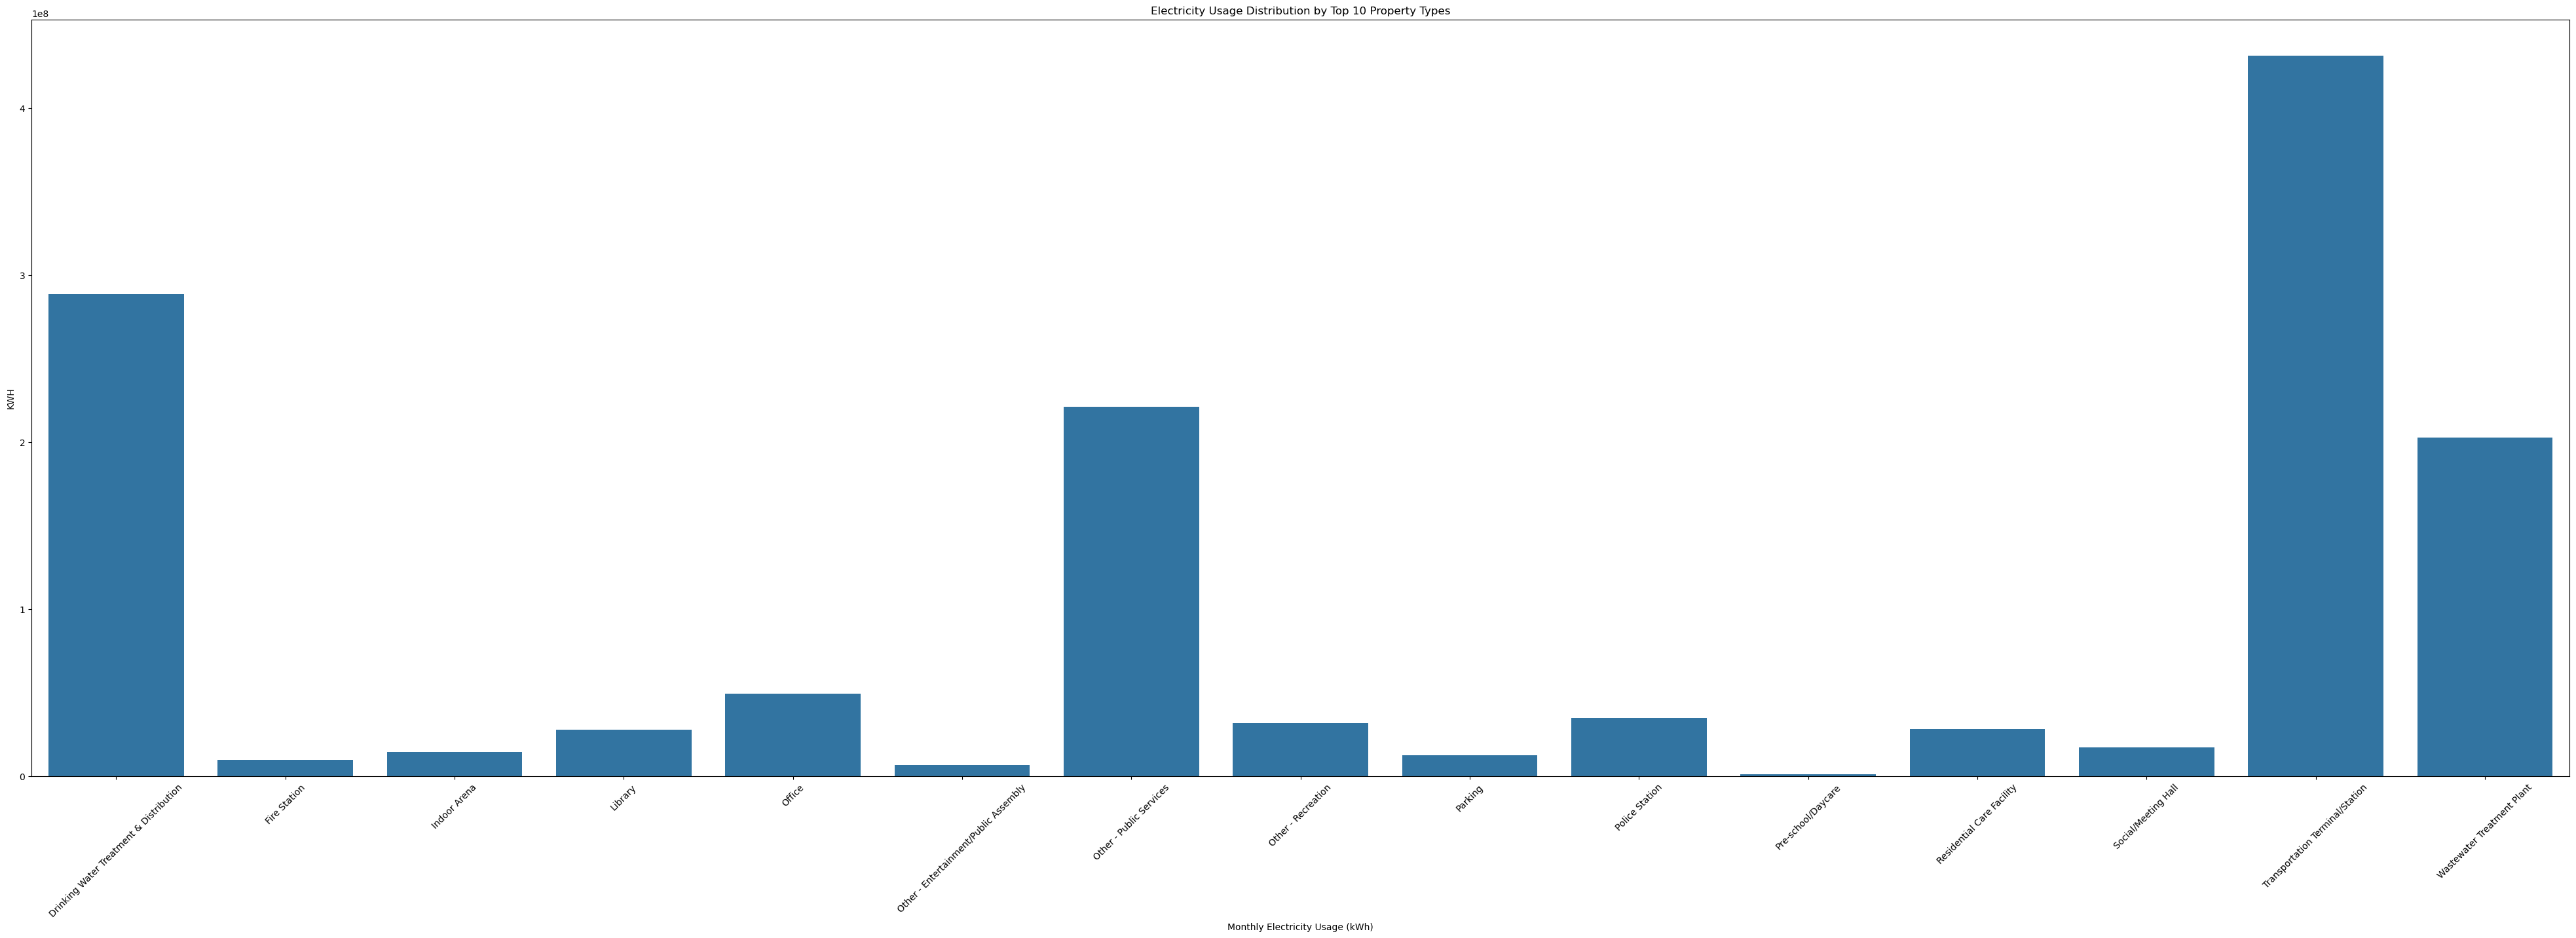

In [133]:
# ----- 4. Consumption by Property Type
df_group_type = df_merged.groupby("Property_Type")["Electricity_Usage_kWh"].sum().reset_index()

display(df_group_type)

plt.figure(figsize=(50, 15))
sns.barplot(
    data = df_group_type,  
    x = "Property_Type",
    y = "Electricity_Usage_kWh"
    )

plt.title("Electricity Usage Distribution by Top 10 Property Types")
plt.xlabel("Monthly Electricity Usage (kWh)")
plt.xticks(rotation=45)
plt.ylabel("KWH")
plt.show()

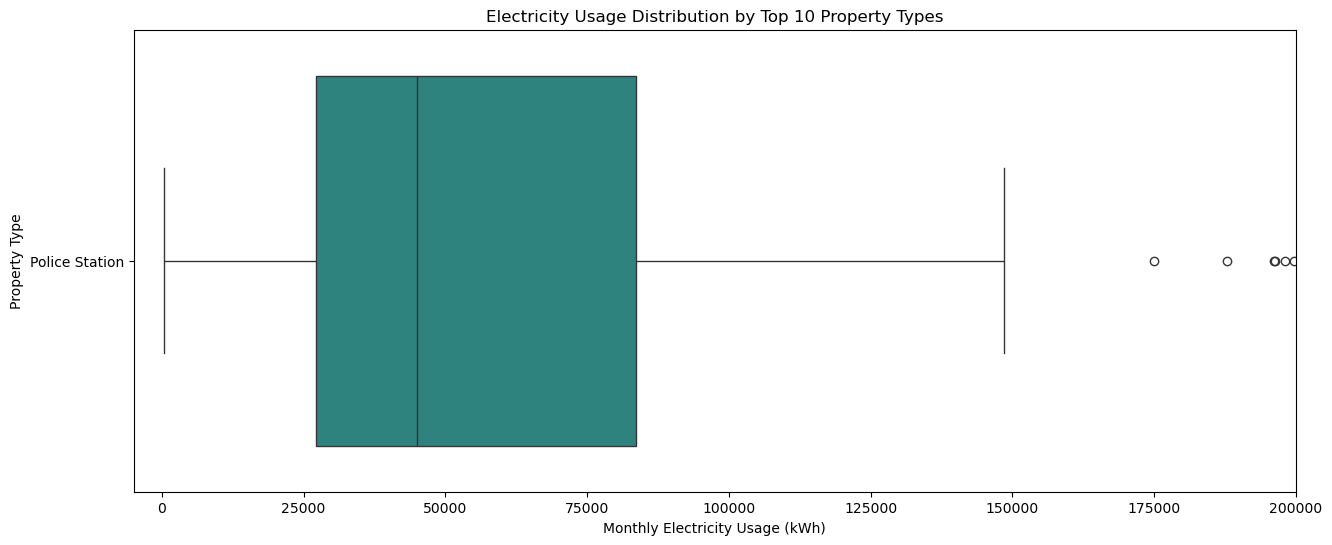

In [134]:
# ----- 4. Consumption by Property Type
df_police = df_merged[df_merged["Property_Type"] == "Police Station"]

plt.figure(figsize=(15, 6))
sns.boxplot(
    data = df_police, 
    x = "Electricity_Usage_kWh", 
    y = "Property_Type",
    hue = "Property_Type",
    legend = False,
    palette = "viridis")

plt.title("Electricity Usage Distribution by Top 10 Property Types")
plt.xlabel("Monthly Electricity Usage (kWh)")
plt.ylabel("Property Type")
plt.xlim(-5000, 200000)
plt.show()

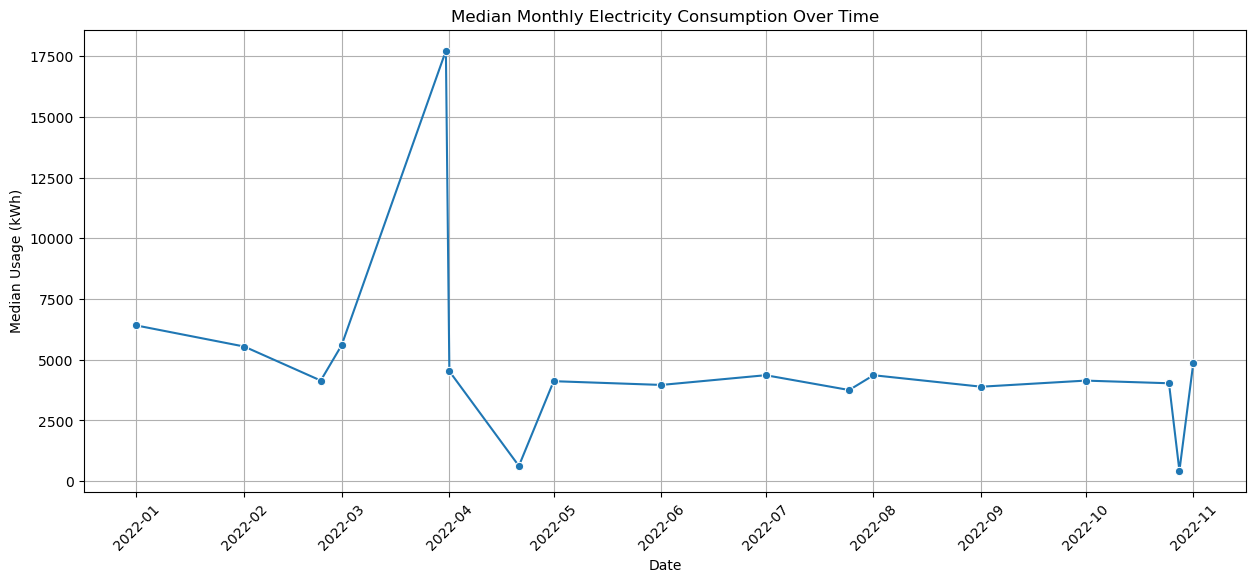

In [135]:
# ----- 5. Time Series Trends
# --- Group by Start Date to see the total consumption trend over time
#df_monthly_trend = df_merged.copy()
df_monthly_trend = df_merged.groupby("Start Date")["Electricity_Usage_kWh"].median().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(
    data = df_monthly_trend,
    x = "Start Date",
    y = "Electricity_Usage_kWh",
    marker = "o")
plt.title("Median Monthly Electricity Consumption Over Time")
plt.xlabel("Date")
#plt.ylabel("Usage (kWh)")
plt.ylabel("Median Usage (kWh)")
plt.grid(True)
plt.xticks(rotation = 45)
plt.show()

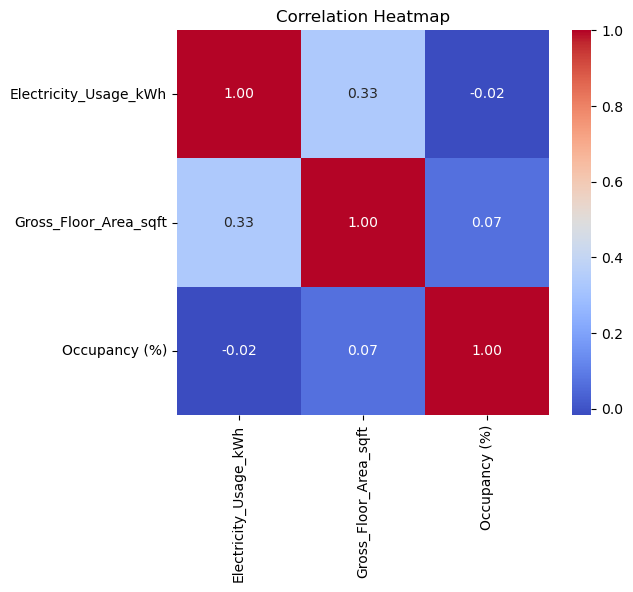

In [136]:
# ----- 6. Correlation Matrix
# --- Select only numeric columns (relevant for correlation)
corr_cols = ["Electricity_Usage_kWh", "Gross_Floor_Area_sqft", "Occupancy (%)"]
correlation_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    data = correlation_matrix,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

### Visualization 

Use visual tools to support and communicate insights.
   * Include plots such as histograms, bar charts, boxplots, or correlation heatmaps.
   * Label axes, titles, and legends clearly.
   * Include visualizations that add value to your analysis.
   * In your report, include figures that convey important insights and explain what they show.


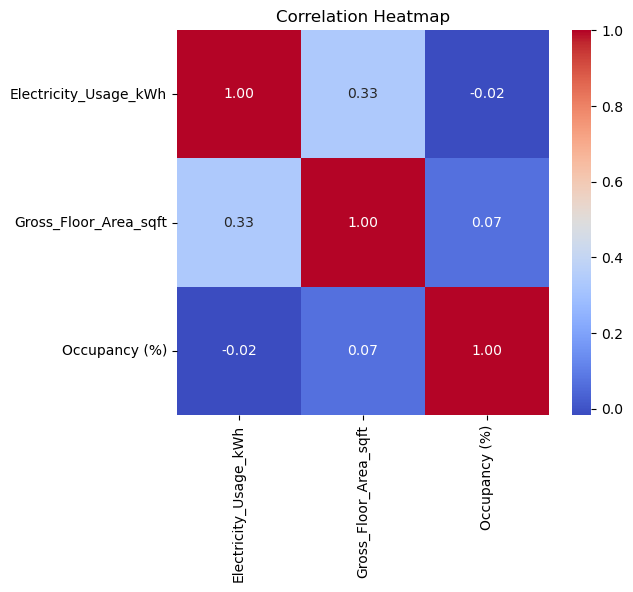

In [137]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    data = correlation_matrix,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

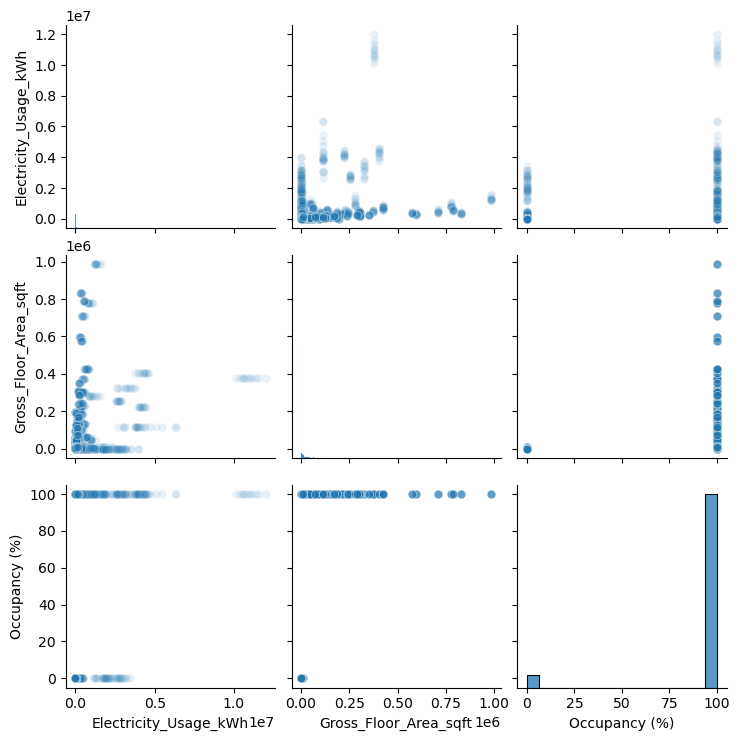

In [138]:
sns.pairplot(
    df_merged[corr_cols],
    plot_kws = {'alpha': 0.1}
    )

### Chart 1
* City vs Usage

### Chart 2
* Use Type vs Usage

### Chart 3
* Gross Floor Area vs Usage

### Chart 4
* Occupancy vs Usage

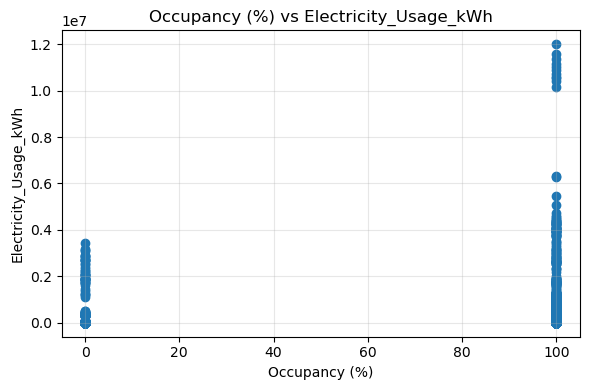

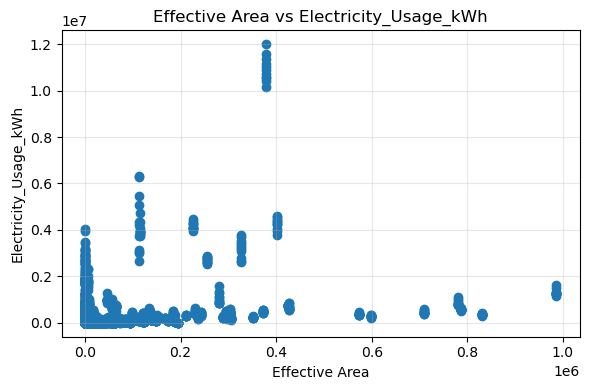

In [139]:
df_merged["Effective_Area"] = (df_merged["Occupancy (%)"] / 100) * df_merged["Gross_Floor_Area_sqft"]

plt.figure(figsize=(6,4))
plt.scatter(df_merged["Occupancy (%)"], df_merged["Electricity_Usage_kWh"])
plt.xlabel("Occupancy (%)")
plt.ylabel("Electricity_Usage_kWh")
plt.title("Occupancy (%) vs Electricity_Usage_kWh")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df_merged["Effective_Area"], df_merged["Electricity_Usage_kWh"])
plt.xlabel("Effective Area")
plt.ylabel("Electricity_Usage_kWh")
plt.title("Effective Area vs Electricity_Usage_kWh")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Chart 5
* Gloss Floor Area vs Electricity KHw

### Feature Engineering

Prepare the dataset for modeling.

   * Create new features where appropriate.
   * Encode categorical variables.
   * Normalize or scale numeric features if needed.
   * In your report, justify why certain features or transformations were used. Explain the reasoning behind selected features and transformations.


### Model Building

Develop prediction models using the cleaned dataset.
   * Build at least two different models (e.g., different algorithms or pipelines).
   * Use an appropriate train–test split.
   * Apply preprocessing such as scaling or encoding when required.
   * Tune hyperparameters where helpful.
   * In your report, describe each model at a high level and the motivation for using it.


### Model Evaluation

Assess model performance thoroughly.

   * Use appropriate metrics for your task.
   * Compare model performance and discuss strengths and weaknesses.
   * Visualize errors or residuals where relevant.
   * Consider issues such as outliers or skewed distributions. You may go back and improve your work in previous steps.
   * **IMPORTANT**: In your report, interpret what the evaluation results mean in context.


### Insights, Interpretation, and Reporting

Synthesize your findings into a coherent narrative.

   * Summarize key insights found during EDA.
   * Discuss which factors appear to influence energy consumption.
   * Explain why certain models performed better than others.
   * Acknowledge limitations, assumptions, or data quality issues.
   * Suggest practical real-world implications or possible next steps.
   * Write your report **clearly, logically, and professionally**.
